In [1]:
%matplotlib qt
import os
import pickle
from sdypy import EMA
import numpy as np
import matplotlib.pyplot as plt 
from EMA_functions import *
import pandas as pd
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as col
import ast
from scipy.io import loadmat

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')
root_video = os.path.normpath('D:/thijsmas/wing')
root_mraw = os.path.normpath('D:/thijsmas/wing/mraw')
root_EMA = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/EMA structure'
root_impact = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Publications/Wind tunnel tests')

roi_size = (7,7)
method = '2d'
file_name =  '1xyz_a_rev6_wcam'
file_name_EMA = file_name + '_' + method + f'_roi{roi_size[0]}x{roi_size[1]}.pkl'

with open(os.path.join(root_EMA, file_name_EMA), 'rb') as f:
    EMA_structure = pkl.load(f)
video = EMA_structure.open_video(add_extension=False)
EMA_structure.root_impact = root_impact
path_impact = os.path.join(root_impact, file_name + '.mat')
impact_data_mat = loadmat(path_impact)

EMA_structure.tp = EMA_structure.maxima
EMA_structure.d  = EMA_structure.displacements
td = EMA_structure.d +  EMA_structure.maxima.reshape(len(EMA_structure.maxima),1,2)

D:/thijsmas\wing\mraw\1xyz_a_rev6_wcam.cih


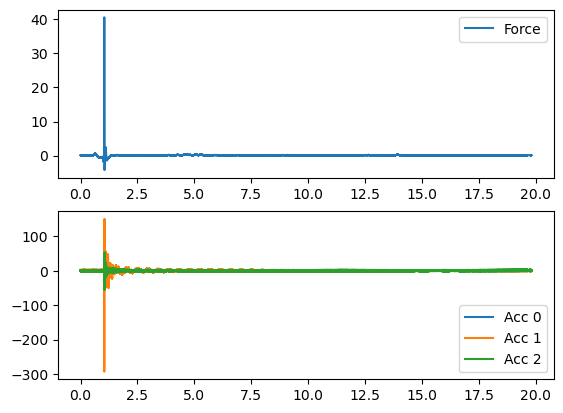

In [3]:
%matplotlib inline
sample_rate = impact_data_mat['H'][0][0][1][0][0]
dt        = 1/sample_rate   
force_raw      = np.squeeze(impact_data_mat['H'][0][0][4])
acc_0_raw     = np.squeeze(impact_data_mat['H'][0][0][6])
acc_1_raw     = np.squeeze(impact_data_mat['H'][0][0][7])
acc_2_raw     = np.squeeze(impact_data_mat['H'][0][0][8])
t_vec_raw       = np.arange(0, len(force_raw)*dt, dt)
fig, ax = plt.subplots(2,1)
ax[0].plot(t_vec_raw, force_raw,    label='Force')
ax[1].plot(t_vec_raw, acc_0_raw,    label='Acc 0')
ax[1].plot(t_vec_raw, acc_1_raw,    label='Acc 1')
ax[1].plot(t_vec_raw, acc_2_raw,    label='Acc 2')
ax[0].legend()
ax[1].legend()

EMA_structure.fs_force      = sample_rate
EMA_structure.fs_camera     = 400
EMA_structure.t_camera_raw  = np.arange(video.info['Total Frame']) / EMA_structure.fs_camera
EMA_structure.force_raw     = force_raw
EMA_structure.t_force_raw   = t_vec_raw

peak_n = 1

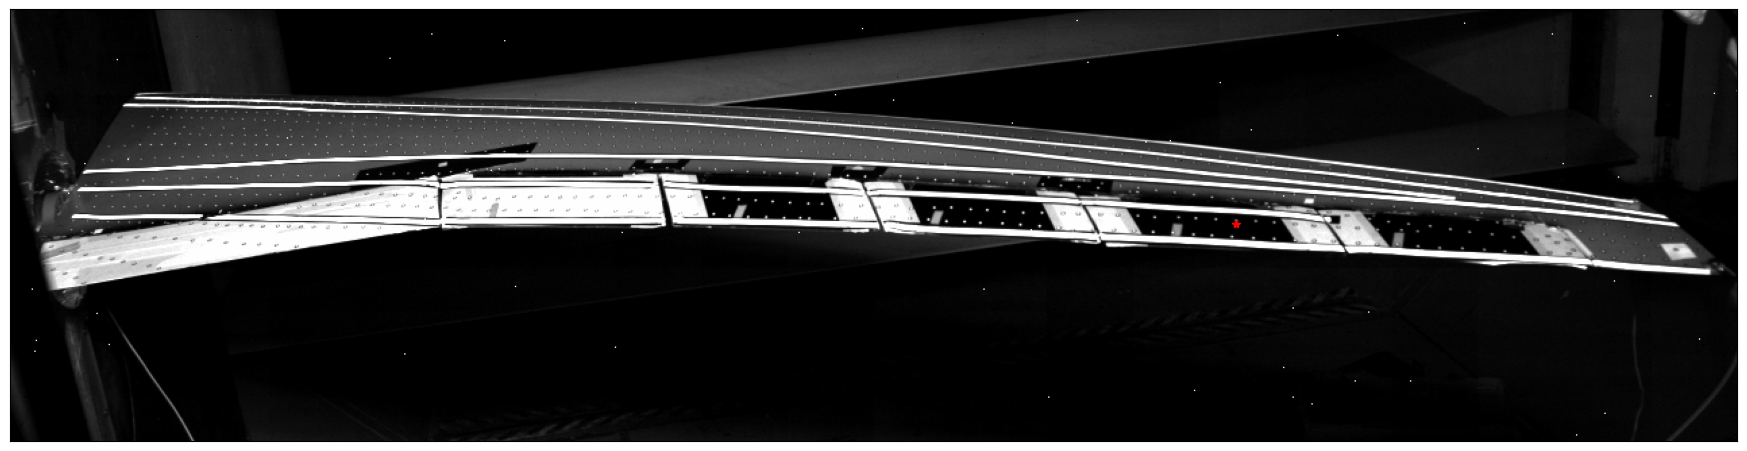

In [19]:
%matplotlib inline
sequential_image_n = 0
EMA_structure.nut_idx((1012, 271), exclude_high_amplitude = True, d_lim =10)
fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation = False, tp_nut = True, tp = False, valid_only=False, bit_depth = 12)

(-5.0, 5.0)

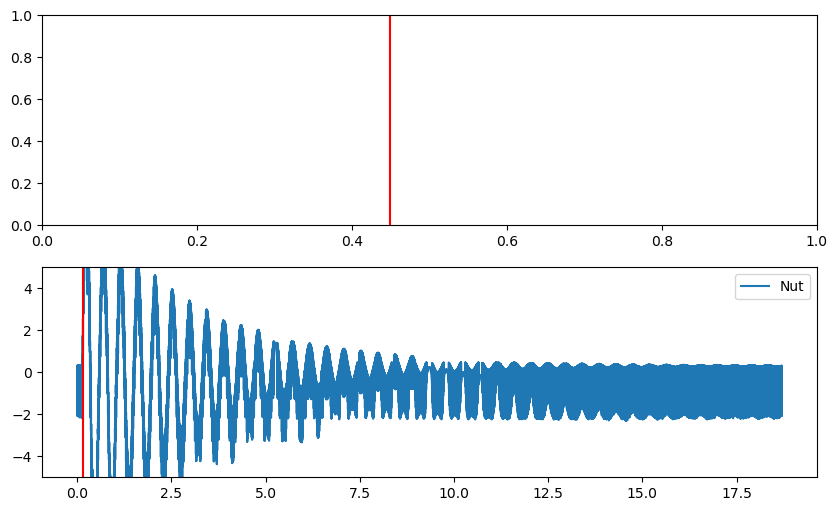

In [24]:
%matplotlib inline
# EMA_structure.initialize_signals()
EMA_structure.initialize_displacement(idx='all', dir='y')

# EMA_structure.nearest_nut_index = 234


fig, ax = plt.subplots(2, 1, figsize=(10, 6))
# ax[0].plot(EMA_structure.t_force_raw, EMA_structure.force_raw)
ax[1].plot(EMA_structure.t_camera_raw, EMA_structure.displacements_raw[EMA_structure.nearest_nut_index], label=f'Nut')
# for node in [132]: #  range(121,140):   #
#     ax[1].plot(EMA_structure.t_camera_raw, EMA_structure.displacements_raw[node], label=f'Node {node}')
if 'first_zero_id_cam' in locals():
    ax[1].axvline(EMA_structure.t_camera_raw[first_zero_id_cam], color='r')
if 'first_zero_id_force' in locals():
    ax[0].axvline(EMA_structure.t_force_raw[first_zero_id_force], color='r')

ax[1].legend()
ax[1].set_ylim(-5,5)

In [21]:
first_zero_id_cam = EMA_structure.find_signal_start(EMA_structure.displacements_raw[EMA_structure.nearest_nut_index], treshold=0.08, approximate_height = 4)
first_zero_id_force = EMA_structure.find_signal_start(EMA_structure.force_raw, peak_n=peak_n, treshold=0.05)
zeros_camera    = EMA_structure.greatest_common_divisor(EMA_structure.fs_camera, EMA_structure.fs_force)
zeros_force     = EMA_structure.n_samples_camera_to_force(zeros_camera)

# Shift and align signals
EMA_structure.t_camera  = EMA_structure.shift_time(EMA_structure.t_camera_raw, EMA_structure.t_camera_raw[first_zero_id_cam-zeros_camera])
EMA_structure.t_force   = EMA_structure.shift_time(EMA_structure.t_force_raw, EMA_structure.t_force_raw[first_zero_id_force-zeros_force])
acc_0                   = EMA_structure.shift_time(acc_0_raw, EMA_structure.t_force_raw[first_zero_id_force-zeros_force])
acc_1                   = EMA_structure.shift_time(acc_1_raw, EMA_structure.t_force_raw[first_zero_id_force-zeros_force])
acc_2                   = EMA_structure.shift_time(acc_2_raw, EMA_structure.t_force_raw[first_zero_id_force-zeros_force])

# Clip signals
EMA_structure.t_camera          = EMA_structure.clip_signal_before(EMA_structure.t_camera,first_zero_id_cam-zeros_camera)
EMA_structure.displacements     = EMA_structure.clip_signal_before(EMA_structure.displacements_raw, first_zero_id_cam-zeros_camera)
EMA_structure.t_force           = EMA_structure.clip_signal_before(EMA_structure.t_force, first_zero_id_force-zeros_force)
EMA_structure.force             = EMA_structure.clip_signal_before(EMA_structure.force_raw, first_zero_id_force-zeros_force)
acc_0                           = EMA_structure.clip_signal_before(acc_0, first_zero_id_force-zeros_force)
acc_1                           = EMA_structure.clip_signal_before(acc_1, first_zero_id_force-zeros_force)
acc_2                           = EMA_structure.clip_signal_before(acc_2, first_zero_id_force-zeros_force)

EMA_structure.t_camera = EMA_structure.t_camera[:-1000]
last_id_force, last_id_camera   = EMA_structure.find_last_common_time_ids(EMA_structure.t_camera, EMA_structure.t_force)
EMA_structure.t_camera          = EMA_structure.clip_signal_after(EMA_structure.t_camera, last_id_camera)
EMA_structure.displacements     = EMA_structure.clip_signal_after(EMA_structure.displacements, last_id_camera)
EMA_structure.t_force           = EMA_structure.clip_signal_after(EMA_structure.t_force, last_id_force)
EMA_structure.force             = EMA_structure.clip_signal_after(EMA_structure.force, last_id_force)
acc_0                           = EMA_structure.clip_signal_after(acc_0, last_id_force)
acc_1                           = EMA_structure.clip_signal_after(acc_1, last_id_force)
acc_2                           = EMA_structure.clip_signal_after(acc_2, last_id_force)

# Zero Force after impact
EMA_structure.force = EMA_structure.zero_signal_treshold(EMA_structure.force, 0.1)
t_end_impact = 0.03
EMA_structure.force = EMA_structure.zero_signal_after(EMA_structure.force, int(t_end_impact*EMA_structure.fs_force))

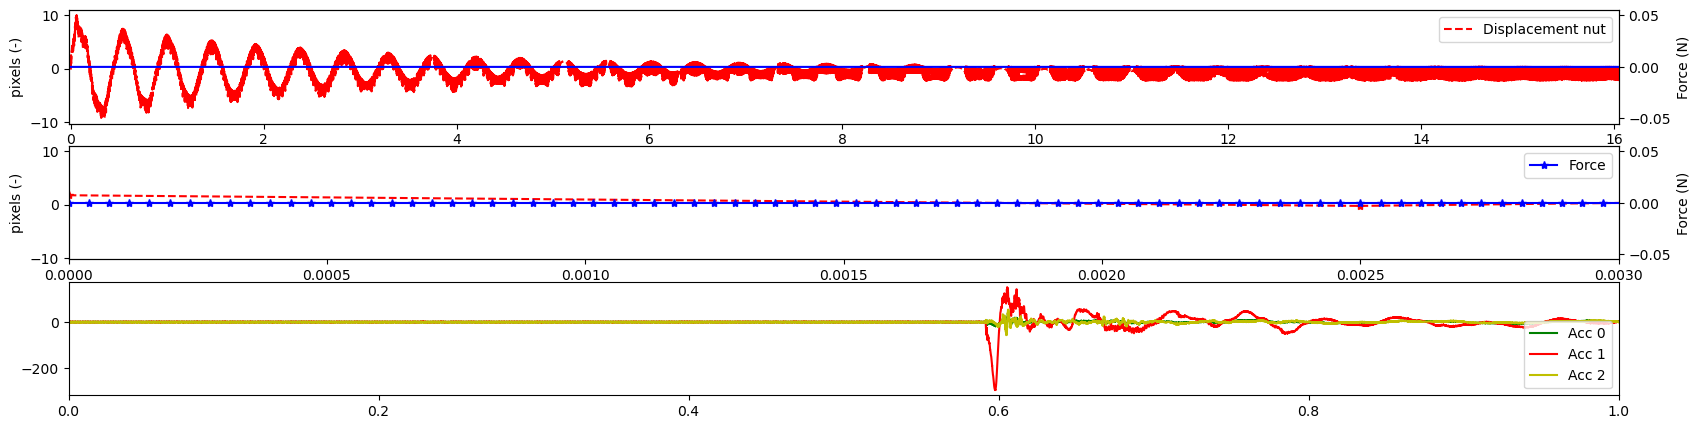

In [22]:
%matplotlib inline
fig, ax = plt.subplots(3,1,figsize=(20,5))
ax0_2 = ax[0].twinx()
ax1_2 = ax[1].twinx()
ax0_2.plot(EMA_structure.t_force, EMA_structure.force,'b-', label='Force (raw))')
ax[0].plot(EMA_structure.t_camera, EMA_structure.displacements[EMA_structure.nearest_nut_index,:],'r--', label=f'Displacement nut')
ax[0].set_xlim([-0.02, EMA_structure.t_camera[-1]])

ax[0].set_ylabel('pixels (-)')
ax0_2.set_ylabel('Force (N)')
ax[0].legend(loc='upper right')


ax1_2.plot(EMA_structure.t_force, EMA_structure.force,'b*-', label='Force')
ax[2].plot(EMA_structure.t_force, acc_0,'g-', label='Acc 0')
ax[2].plot(EMA_structure.t_force, acc_1,'r-', label='Acc 1')
ax[2].plot(EMA_structure.t_force, acc_2,'y-', label='Acc 2')
ax[1].plot(EMA_structure.t_camera, EMA_structure.displacements[EMA_structure.nearest_nut_index,:],'r*--', label=f'Displacement nut')
# ax[1].plot(t_camera2[disp_peaks], disp_nut[disp_peaks], 'rx')
ax[1].set_xlim([0, 0.003])
ax[1].set_ylabel('pixels (-)')
ax1_2.set_ylabel('Force (N)')

# set legend to north east
ax1_2.legend()
ax[2].legend()
ax[2].set_xlim([0, 1])
ax[1].set_xlabel('Time (s)')
plt.show()
# fig.savefig(os.path.join(EMA_structure.root_simulations, 'signals', f'{EMA_structure.file_name} - example impact.png'), dpi=300, bbox_inches='tight')

In [23]:
%matplotlib qt
# Feature filtering parameters for the 2D signals
# d_lim = 10
# z_limit = 0.2
# d_min = 0.9
# f_range = (3, 50)
# H_max_lim = 2e6
# H_peak_min = 2
# smooth_lim = 500
# max_drift = 1.

# Feature filtering parameters for the 1D signals
d_lim = 20
z_limit = 0.25
d_min = 0.1
f_range = (3, 150)
# H_max_lim = 1e6
H_peak_min = 2
smooth_lim = .9
max_drift = 2
max_end_drift = 1.5

EMA_structure.set_freq_properties(padding_ratio=1)
EMA_structure.get_transfer_function()
EMA_structure.valid_tp(d_lim = d_lim, z_limit = z_limit, h_type = 'H1', d_min=d_min, f_range= f_range)

smooth_signals = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < smooth_lim
non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d[:,:-100], axis=2), axis=1) < max_drift)
# non_drifting2 = np.abs(np.linalg.norm(EMA_structure.d[:,-1], axis=1)) < max_end_drift
# H_max = np.max(np.abs(EMA_structure.H1), axis=1)
# H_low = H_max<H_max_lim
# H_peak_loc = np.argmax(np.abs(EMA_structure.H1), axis=1)
# sd_points = H_peak_loc>H_peak_min

EMA_structure.valid_tps = EMA_structure.valid_tps  & smooth_signals # & non_drifting # & sd_points # & non_drifting2 & sd_points#& H_low
# EMA_structure.valid_tps =  smooth_signals & H_low & non_drifting & EMA_structure.valid_tps & sd_points# & non_drifting & H_low &

print(np.sum(~EMA_structure.exclude_outliers))
print(f'Number of valid points is: {len(EMA_structure.tp[EMA_structure.valid_tps])}/{EMA_structure.tp.shape[0]}')
ani = EMA_structure.play_video(video, range(300,video.N - 1), interval=30, points=td[EMA_structure.valid_tps])


# print(np.sum(~smooth_signals), np.sum(~non_drifting), np.sum(~non_drifting2), np.sum(~sd_points), np.sum(~H_low), np.sum(~EMA_structure.valid_tps))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for disp_i in EMA_structure.d[EMA_structure.valid_tps, :, 0]:
    ax.plot(EMA_structure.t_camera_raw, disp_i, 'r', alpha=0.2, linewidth=0.2)
# ax.plot(EMA_structure.t_camera, np.mean(EMA_structure.displacements[EMA_structure.valid_tps], axis=0), 'k', label='Mean displacement')

c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:683: RuntimeWarning: invalid value encountered in divide
  self.H1 = S_fx / S_ff
c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:684: RuntimeWarning: divide by zero encountered in divide
  self.H2 =  S_xx / S_xf
c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:684: RuntimeWarning: invalid value encountered in divide
  self.H2 =  S_xx / S_xf
c:\Users\thijsmas\Documents\GitHub\pyidi\scripts\EMA_functions.py:685: RuntimeWarning: invalid value encountered in divide
  self.Hv =  (S_fx / S_ff * S_xx / S_xf)**0.5


813
Number of valid points is: 0/813


In [ ]:
T_acc  = EMA_structure.t_force[-1]
acc_fft              = EMA_structure._FFT_on_signal(acc_1, EMA_structure.n_f)
acc_fft[1:] *= 2
n_freq = len(EMA_structure.freq_camera)
acc_fft = acc_fft[:n_freq]

S_xx = 1/T_acc * np.conj(acc_fft) * acc_fft
S_ff = 1/T_acc * np.conj(EMA_structure.force_fft) * EMA_structure.force_fft
S_xf = 1/T_acc * np.conj(acc_fft) * EMA_structure.force_fft
S_fx = 1/T_acc * np.conj(EMA_structure.force_fft) * acc_fft
H1_acc = S_fx / S_ff
cam_acc = EMA.Model(H1_acc, EMA_structure.freq_camera, lower=1, upper=65, pol_order_high=50, frf_type = 'accelerance')
cam_acc.get_poles(show_progress=True)
cam_acc.select_poles()

In [ ]:
cam = EMA.Model(EMA_structure.H1[EMA_structure.valid_tps], EMA_structure.freq_camera, lower=1, upper=65, pol_order_high=50, frf_type = 'receptance')
H, A = cam.get_constants(whose_poles=cam_acc)
cam.nat_freq    = cam_acc.nat_freq
cam.nat_xi      = cam_acc.nat_xi
# cam.get_poles(show_progress=True)
# cam.select_poles()


In [ ]:
cam.print_modal_data()
fig, ax = plot_FRF(cam)
fig = plot_MAC(cam, n_modes = len(cam.nat_freq))

In [ ]:
%matplotlib qt
root_mode_shapes = os.path.join(EMA_structure.root_simulations, 'web mode shapes', EMA_structure.file_name) #_1D_roi3x3

if not os.path.exists(root_mode_shapes):
    os.makedirs(root_mode_shapes)

for mode_number in range(len(cam.nat_freq)): #[2]: #  # range(14,n_modes): #  [22]: # 
    print(f'mode_number: {mode_number}')
    ani  = animate_mode_shape(cam, mode_number, EMA_structure.tp[EMA_structure.valid_tps]) #, indices_to_plot = indices_to_plot np.delete(tp_lim, biggest_outliers, axis=0)
    writer = animation.FFMpegWriter(fps=60)
    ani.save(os.path.join(root_mode_shapes, f'Mode_shape_{EMA_structure.file_name}_{mode_number}_1d.mp4'), writer=writer)
    plt.close()

In [ ]:
%matplotlib inline
def plot_flat_mode_shape(cam, mode_number, tp, node, ax):
    A = cam.A
    A_imag = np.imag(A[:, mode_number])# / np.linalg.norm(A[:, mode_number])
    A_real = np.real(A[:, mode_number])# / np.linalg.norm(A[:, mode_number])

    A_abs = np.abs(A[:, mode_number])
    top_95_percentile_value = np.percentile(A_abs, 95)
    top_95_percentile_node = np.argmin(np.abs(A_abs - top_95_percentile_value))

    # node = np.argmax(np.abs(A[:, mode_number]))

    An_i = np.linalg.norm(A[top_95_percentile_node, mode_number])
    An_r = np.linalg.norm(A[top_95_percentile_node, mode_number])
    t_vec = np.linspace(0, 2 * np.pi, 100)
    A_max = 0
    t_max = 0
    for t in t_vec:
        A = An_i * np.sin(t) + An_r * np.cos(t)
        if A < A_max:
            A_max = A
            t_max = t

    Z = A_imag * np.sin(t_max) + A_real * np.cos(t_max)
    top_95_percentile = np.percentile(Z, 95)
    bot_5_percentile = np.percentile(Z, 5)
    v_max = top_95_percentile *1.11
    v_min = bot_5_percentile * 0.89
    if v_min>v_max:
        v_min = np.min(Z)
        v_max = np.max(Z)

    cmap = plt.cm.get_cmap('seismic')
    ax.scatter(tp[:, 1], -tp[:, 0], c=Z, cmap=cmap, s=2, vmax=v_max, vmin=v_min)
    return ax
fn_n = len(cam.nat_freq)
rows, columns  = (2,2)
fig, ax = plt.subplots(rows, columns)
for mode in range(fn_n): #[12]: #
    mode_i, mode_j = np.unravel_index(mode, (rows, columns))
    ax[mode_i, mode_j] = plot_flat_mode_shape(cam, mode, EMA_structure.tp[EMA_structure.valid_tps], EMA_structure.nearest_nut_index+1, ax[mode_i, mode_j])
    # ax[mode_i, mode_j].set_aspect('equal')
    ax[mode_i, mode_j].set_xticks([])
    ax[mode_i, mode_j].set_yticks([])
    ax[mode_i, mode_j].set_title(f'{mode+1}: {cam.nat_freq[mode]:.1f} Hz')

# if test == '1D':
#     fig.savefig(os.path.join(EMA_structure.root_simulations, 'web mode shapes flat', f'Mode_shapes_flat_{EMA_structure.file_name}_1D_roi3x3_3.png'), dpi=300, bbox_inches='tight')
# elif test == '2D':
#     # fig.savefig(os.path.join(EMA_structure.root_simulations, 'web mode shapes flat', f'Mode_shapes_flat_{EMA_structure.file_name}_2D_roi5x5_2.png'), dpi=300, bbox_inches='tight')
#     fig.savefig(os.path.join(EMA_structure.root_simulations, 'web mode shapes flat', f'Mode_shapes_flat_{EMA_structure.file_name}_2D_roi7x7_2.png'), dpi=300, bbox_inches='tight')